In [ ]:
# display some images for every different expression

import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

# size of the image: 48*48 pixels
pic_size = 48

In [ ]:
! kaggle datasets download jonathanoheix/face-expression-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
License(s): unknown
face-expression-recognition-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip face-expression-recognition-dataset.zip


Archive:  face-expression-recognition-dataset.zip
replace images/images/train/angry/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
base_path = "/content/images/"

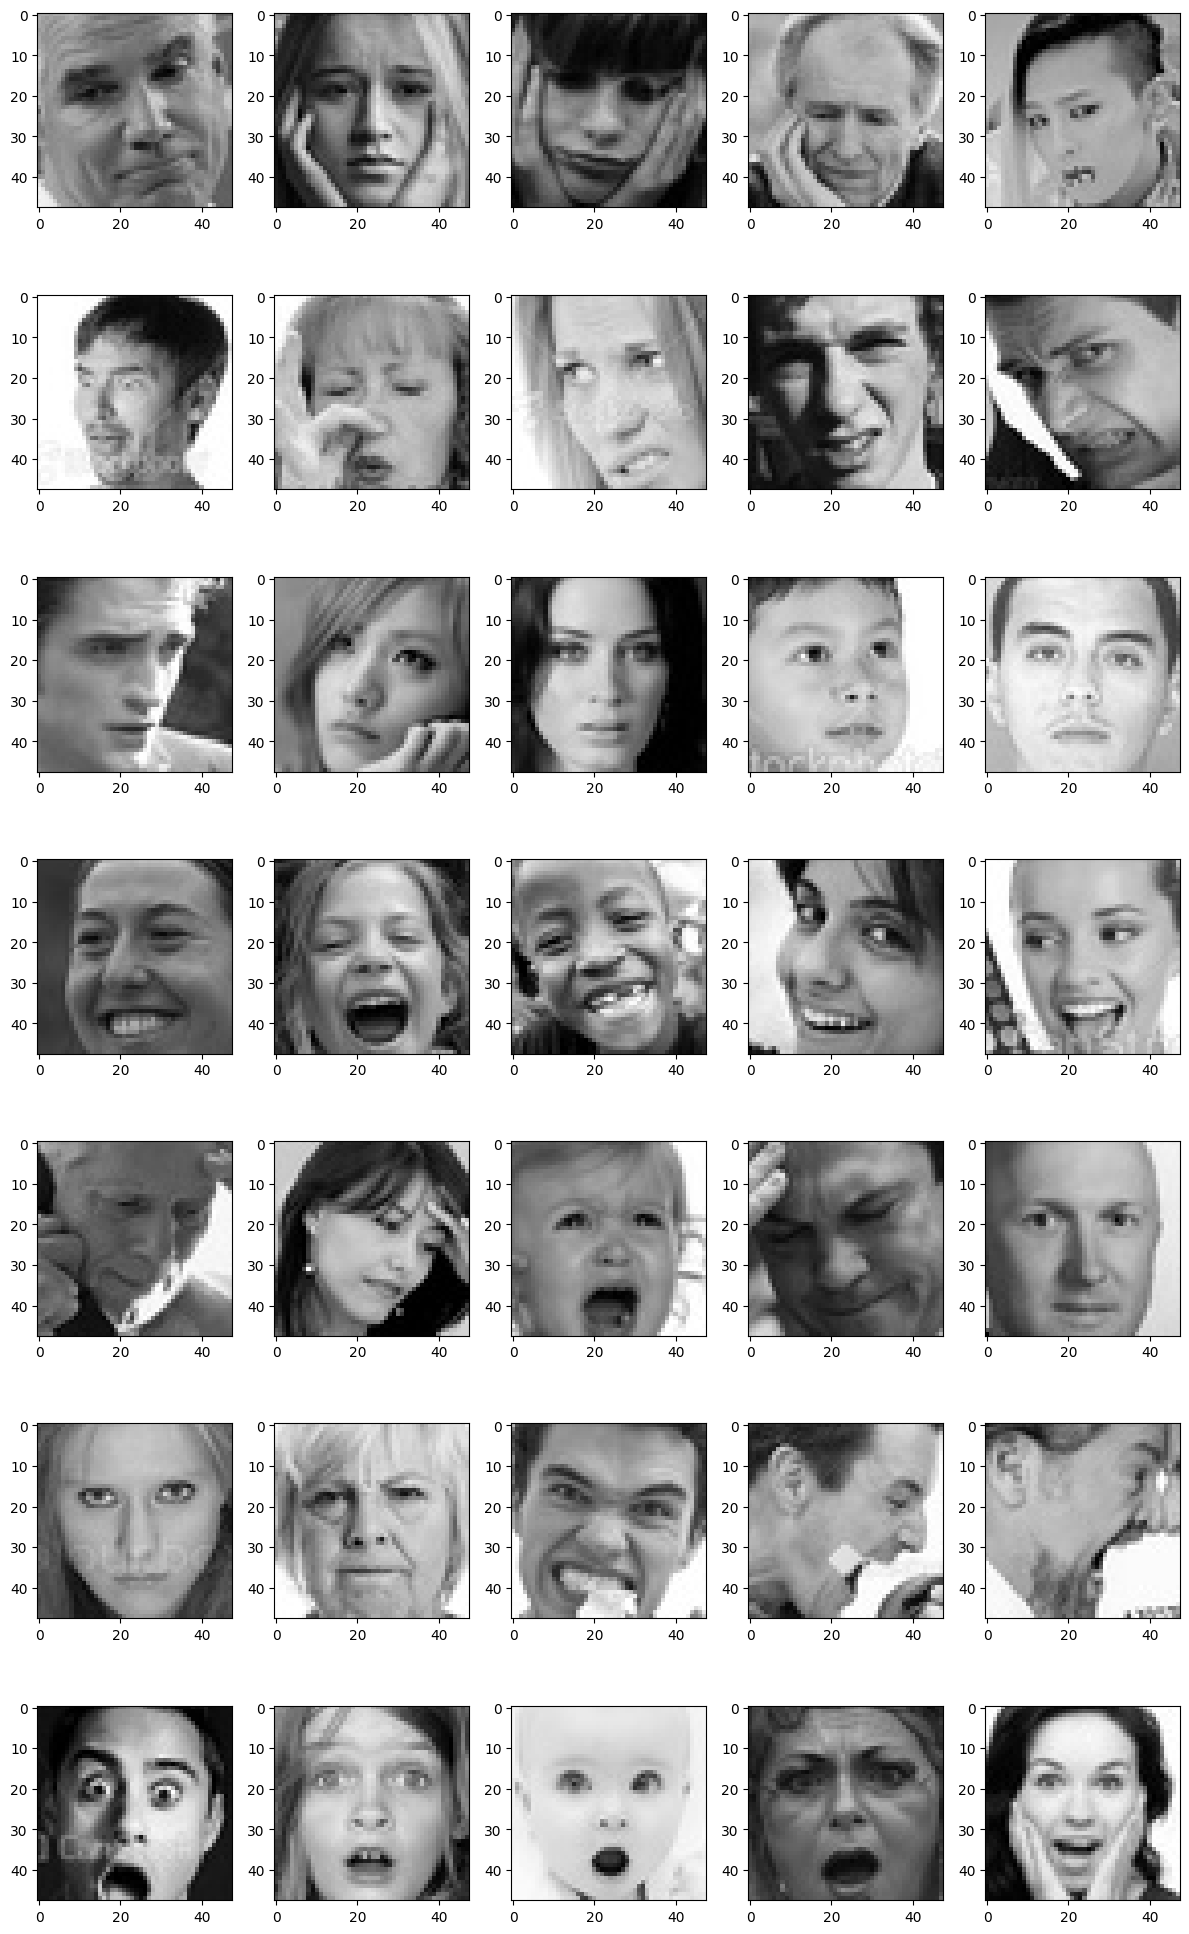

In [ ]:
plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "train"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 128

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 20,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale= 1.0/255)

train_generator = train_datagen.flow_from_directory(base_path + "train",
                                                    target_size=(56,56),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 28821 images belonging to 7 classes.


In [ ]:
validation_generator = validation_datagen.flow_from_directory(base_path + "validation",
                                                    target_size=(56,56),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 7066 images belonging to 7 classes.


In [ ]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

model.add(Conv2D(64,(3,3), padding='same', input_shape=(56, 56,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

print(model.summary())

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 56, 56, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 56, 56, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 28, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 28, 28, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       2

None


In [ ]:
# Assuming train_generator is your ImageDataGenerator instance
class_indices = train_generator.class_indices
print(class_indices)


{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
epochs = 50

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/50


<ipython-input-10-8d95aff573e7>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


225/225 [==============================] - ETA: 0s - loss: 1.9107 - accuracy: 0.2416
Epoch 1: val_accuracy improved from -inf to 0.17273, saving model to model_weights.h5
225/225 [==============================] - 46s 151ms/step - loss: 1.9107 - accuracy: 0.2416 - val_loss: 1.9527 - val_accuracy: 0.1727


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
225/225 [==============================] - ETA: 0s - loss: 1.6641 - accuracy: 0.3460
Epoch 2: val_accuracy improved from 0.17273 to 0.33892, saving model to model_weights.h5
225/225 [==============================] - 34s 149ms/step - loss: 1.6641 - accuracy: 0.3460 - val_loss: 2.0640 - val_accuracy: 0.3389
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 1.4784 - accuracy: 0.4308
Epoch 3: val_accuracy improved from 0.33892 to 0.42585, saving model to model_weights.h5
225/225 [==============================] - 31s 136ms/step - loss: 1.4784 - accuracy: 0.4308 - val_loss: 1.4498 - val_accuracy: 0.4259
Epoch 4/50
225/225 [==============================] - ETA: 0s - loss: 1.3717 - accuracy: 0.4705
Epoch 4: val_accuracy improved from 0.42585 to 0.48466, saving model to model_weights.h5
225/225 [==============================] - 31s 136ms/step - loss: 1.3717 - accuracy: 0.4705 - val_loss: 1.3476 - val_accuracy: 0.4847
Epoch 5/50
225/225 [=======================

In [ ]:
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize = (24, 6))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')



    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()

def get_best_epoch(history):
    valid_acc = history.history['val_accuracy']
    best_epoch = valid_acc.index(max(valid_acc)) + 1
    best_acc =  max(valid_acc)
    print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format( best_acc, best_epoch))
    return best_epoch

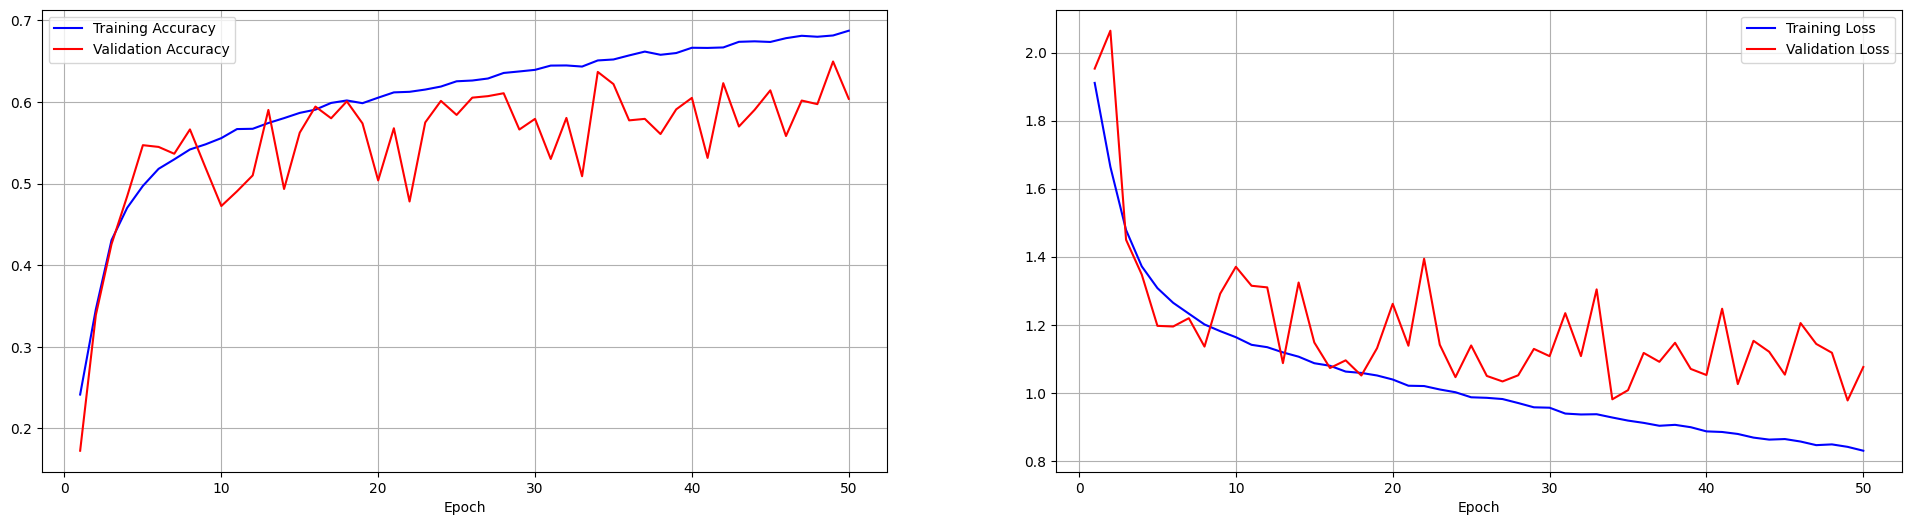

Best Validation Accuracy Score 0.64972, is for epoch 49


In [ ]:
plot_results(history)
best_epoch =get_best_epoch(history)

In [ ]:
from keras.models import load_model


model.save('modelaccurate.h5')

In [ ]:
model_json = model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.models import model_from_json

In [ ]:
model_json_file = '/content/model_architecture.json'
model_weights_file = '/content/model_weights.h5'
with open(model_json_file, "r") as json_file:
    loaded_model_json = json_file.read()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(model_weights_file)


In [ ]:
face_cascade = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')

In [ ]:

cap = cv2.VideoCapture(0)
import copy
if not cap.isOpened():
    print("Error opening video stream or file")
    exit()  # Exit the script if the camera can't be opened

while True:

    ret, frame = cap.read()
    if not ret:  # Check if a frame was successfully read
        break
while True:

    ret, frame = cap.read()
    img = copy.deepcopy(frame)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        fc = gray[y:y+h, x:x+w]

        roi = cv2.resize(fc, (48,48))
        pred = loaded_model.predict(roi[np.newaxis, :, :, np.newaxis])
        text_idx=np.argmax(pred)
        text_list = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
        if text_idx == 0:
            text= text_list[0]
        if text_idx == 1:
            text= text_list[1]
        elif text_idx == 2:
            text= text_list[2]
        elif text_idx == 3:
            text= text_list[3]
        elif text_idx == 4:
            text= text_list[4]
        elif text_idx == 5:
            text= text_list[5]
        elif text_idx == 6:
            text= text_list[6]
        cv2.putText(img, text, (x, y-5),
           cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 255), 2)
        img = cv2.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 2)


    cv2.imshow("frame", img)
    key = cv2.waitKey(1) & 0xFF
    if key== ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Error opening video stream or file


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
